# Part 3 AIE Graph Programming and Performance Analyze 

The third part goes through the steps on creating the ADF graph and analyze the performance.

- Create the kernel Graph and the test bench
- Compare with AIE HW Emulation result with the SW result
- Analyze performance and accuracy

## Step 1: Create the Single Kernel ADF Graph

An adaptive data flow (ADF) graph is a network with a single AI Engine kernel or multiple AI Engine kernels connected by data streams. The graph can interact with the programmable logic (PL), global memory, and/or the host processor using specific constructs.

This following process describes how to construct data flow graphs in C++.

1. Define your application graph class in a separate header file (for example project.h). First, add the Adaptive Data Flow (ADF) header (adf.h) and include the kernel function prototypes. The ADF library includes all the required constructs for defining and executing the graphs on AI Engines.

```c++
#include "aie_kernels.h"
#include "system_settings.h"
```

2. Define your graph class by using the objects which are defined in the adf namespace. All user graphs are derived from the class graph.

```c++
using namespace adf;

class Fir_Lowpass16 : public graph {
private:
	kernel k1;
}

```
This is the beginning of a graph class definition that declares two kernels (first and second).

3. Add some top-level input/output objects, input_plio and output_plio, to the graph.

```c++
using namespace adf;

class Fir_Lowpass16 : public graph {
private:
	kernel k1;
public:
  input_plio in;
  output_plio out;

};
```

4. Use the kernel::create function to instantiate the first and second C++ kernel objects using the functionality of the C function simple.

```c++
using namespace adf;

class Fir_Lowpass16 : public graph {
private:
	kernel k1;
public:
	input_plio in;
	output_plio out;

	Fir_Lowpass16()
	{
		//Create Kernel
		k1 = kernel::create(fir_16taps_symm);
	};
};
```

5. Configure input/output objects with specified PLIO width and input/output files, and add the connectivity information, which is equivalent to the nets in a data flow graph. In this description, input/output objects are referenced by indices. The first input buffer or stream argument in the simple function is assigned index 0 in an array of input ports (in). Subsequent input arguments take ascending consecutive indices. The first output buffer or stream argument in the simple function is assigned index 0 in an array of output ports (out). Subsequent output arguments take ascending consecutive indices.

**Question 4:** How to define the buffer size of the window-based connection?

The size of the window buffer is related to the length and width of sample data flowing through each node in the graph.
In this case, the total number of bytes on flowing through the PLIO port and kernel port is the number of samples plus the number of byte per sample. Please refer to this [link](https://docs.xilinx.com/r/en-US/ug1079-ai-engine-kernel-coding/Graph-Conversiond) for the latest connect statements with buffer port to buffer port.

```c++
Fir_Lowpass16()
{
	// Create the PLIO ports
	in = input_plio::create("DataIn", plio_32_bits, "data/input.txt", 250.0);
	out = output_plio::create("DataOut", plio_32_bits, "data/output.txt", 250.0);		

	//Create Kernel
	k1 = kernel::create(fir_16taps_symm);

	// Create nets to connect kernels and IO ports
	connect< window<INPUT_SAMPLES*NBYTES_DATA > net1 (in.out[0],k1.in[0]);
	connect< window<OUTPUT_SAMPLES*NBYTES_DATA> > net2 (k1.out[0],out.in[0]);

	// Specify kernel sources
	source(k1) = "aie_kernels/fir_16taps_symm.cpp";

	// Specify kernel runtime
	runtime<ratio>(k1) = 0.8;
};

```

The following figure represents the graph connectivity specified in the previous graph code. Graph connectivity can be viewed when you open the compilation results in the Vitis Analyzer. 

![array](./image/array.png)



## Step 2: Create the AIE C Test Bench and Run the x86 Functional Simulation

This AIE C test bench flow requires you code stimuli and read the response in C/C++. The advantage of this approach is that you work in the same native tool flow used for kernel development. This allows cross-probing between the test code and the kernel source code as well as breakpoints, single-stepping and register watches to support debugging. The disadvantage is the limited options for generating and monitoring signals. No worry, we have already learn to generate, monitor and plot the signals using Python in Juypter Notebook:

The following sample code shows the test bench that is used to validate the AI Engine application.
1. The included ADF library.
2. The AI Engine graph.
3. And the main() function, which controls the simulation.
4. The run() method starts the graph execution by enabling the processors. This graph runs 4 times because the number of iterations to be run is provided to the run(4).

```c++
#include "project.h"
using namespace adf;
FirstGraph mygraph;
#if defined(__AIESIM__) || defined(__X86SIM__)
int main(void) {
  
  mygraph.init();
  mygraph.run(4);
  mygraph.wait(10000);
  mygraph.resume();
  mygraph.update();
  mygraph.end();
  return 0;
}
#endif
```

For the current example an advanced test bench would be as [this](../aie/src/graph.cpp).
The starting point includes writing kernel output to a file post-analysis, longer data sets, and adding golden data reference file for comparison in order to issue a pass-fail verdict. 

1. Navigate to the $HOME/ folder and run make all to build the AIE project

```sh
        cd $HOME/fir_lowpass/aie
        make all TARGET=x86sim
```

2. Run the x86 simulation

```sh
        make x86sim TARGET=x86sim
```
3. Check the x86 simulation comparison results in the terminal
   
```sh
Number of Output: 1024
Number of CORRECT output: 1024
Number of WRONG   output: 0
```

## Step 3: Build the AIE Kernel and Run the AIE Emulation and Compare the AIE and SW Filter Results

This lab will use Makefile files to automate the building process.

1. Navigate to the $HOME/ folder and run make all to build the AIE project

```sh
        cd $HOME/xup_aie_training/pbl/aie_single_kernel/fir_lowpass/aie
        make all
```

2. Run the AIE Emulation

```sh
        make aieemu
```

3. Analyze the AIE Emulation and compilation results

```sh
        make analyzer
```

4. Copy the AIE Emulation result

```sh
        make get_output
```

The output files can be found here: `./data/output_aie.txt`

5. Compare the AIE and SW filter results

SW filtered signal
AIE filtered signal


C:\Users\wenc\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


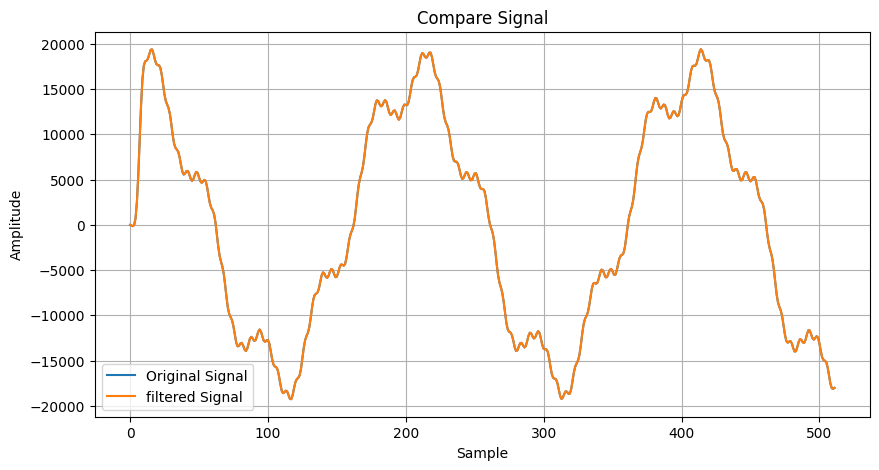

array([ True,  True,  True, ...,  True,  True,  True])

In [1]:
import sys
import numpy as np
from scipy.signal import kaiserord, lfilter, firwin, freqz

import sys
sys.path.append('../../../common')
from aie_signals import SignalPlotter
from aie_signals import SignalGenerator
from aie_file import FileGen

input_data = FileGen().read_cmpx('../aie/data/input.txt', 1024)
lpf_coeffs_hw = [ -29, -115, -122, 268, 1379, 3209, 5226, 6566, 6566, 5226, 3209, 1379,  268, -122, -115, -29]

filtered_signal = lfilter(lpf_coeffs_hw, 1.0, input_data)
SW_filtered_signal = np.round(filtered_signal * (2 ** -15))

print("SW filtered signal")
plotter = SignalPlotter(SW_filtered_signal)

print("AIE filtered signal")
AIE_filtered_signal = FileGen().read_cmpx('../aie/data/output_aie.txt', 1024)

plotter = SignalPlotter(SW_filtered_signal,AIE_filtered_signal)
plotter.compare_signal(512)

np.isclose(SW_filtered_signal, AIE_filtered_signal, 10, 10)

## Step 4: Performance Analysis

The AI Engine simulator output contains a timestamp for each piece of output data. It is possible to make performance calculations both manually and by using scripts. For example, the output of the example (`aie/build.hw/aiesimulator_output/data/output.txt`) looks like the following:

```
T 1664 ns
0 0 
......

T 5664 ns
TLAST
-136 789 
```

In addition to estimating latency and throughput using the timestamps of AIE simulator output files, you can also calculate computational latency and transmission latency for each iteration by timestamping data in the Vitis timeline trace viewer. Throughput can be calculated by marking the data obtained. The following figure shows the data output timestamps. The first samples come out at 1,672 ns, the last samples of the first iteration come out at 2,590 ns, and the last samples of come out at 5,664 ns. 

<img src="./image/timeline_trace.png" alt="ADF Image" width="1000" height="450">

The throughput therefore can be calculated as follows:

1. Throughput per iteration

```
 Total time = 2590 - 1672 = 918 ns
 Total bytes per iteration = Input Sample * Bytes per data = 256 * 4 = 1024  bytes
 Throughput = 1024/918 = 1.11 GB/s
```

2. Throughput per execution

```
Processing time = (End Timestamp of strmInpFromFIR - Start Timestamp of strmInpFromFIR)
		= 5664 - 1664
		= 4000 ns
		
Throughput = (Input Sample * Iterations) /(Processing time)
			= (256 x 4 ) / 4000 ns
			= 256 Msamples / sec
```

This method does not measure the latency of the first kernel execution to produce the output data. Make sure that the graph runs a number large enough that this overhead can be neglected.

--------------

 

<center>

 

Copyright&copy; 2023 AMD, Inc

 

SPDX-License-Identifier: MIT

 

</center>